In [355]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [356]:
df=pd.read_csv("Data/FoodBalanceSheets_E_All_Data/FoodBalanceSheets_E_All_Data_NOFLAG.csv", encoding="latin-1")

In [357]:
df.drop(["Area Code","Item Code","Element Code"],axis=1,inplace=True)
df

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,Afghanistan,Population,Total Population - Both sexes,1000 persons,29186.00,30117.00,31161.00,32270.00,33371.00,34414.00,35383.00,36296.00,37172.00,38042.00
1,Afghanistan,Population,Domestic supply quantity,1000 tonnes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Afghanistan,Grand Total,Food supply (kcal/capita/day),kcal/capita/day,2170.00,2152.00,2159.00,2196.00,2265.00,2250.00,2228.00,2303.00,2270.00,2273.00
3,Afghanistan,Grand Total,Protein supply quantity (g/capita/day),g/capita/day,59.23,58.00,57.82,57.71,60.17,58.45,58.46,59.50,57.62,57.31
4,Afghanistan,Grand Total,Fat supply quantity (g/capita/day),g/capita/day,36.69,34.81,36.53,37.10,41.48,38.28,40.70,40.03,41.46,39.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319738,Net Food Importing Developing Countries,Miscellaneous,Food,1000 tonnes,787.00,839.00,921.00,935.00,958.00,992.00,1032.00,1066.00,1140.00,1199.00
319739,Net Food Importing Developing Countries,Miscellaneous,Food supply quantity (kg/capita/yr),kg,0.62,0.65,0.68,0.67,0.67,0.68,0.69,0.70,0.73,0.75
319740,Net Food Importing Developing Countries,Miscellaneous,Food supply (kcal/capita/day),kcal/capita/day,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
319741,Net Food Importing Developing Countries,Miscellaneous,Protein supply quantity (g/capita/day),g/capita/day,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


In [358]:
df.dropna(axis=0, inplace=True)

In [359]:
df=df.loc[~(df.iloc[:,4:]==0).all(axis=1)]

In [361]:
df.Area.value_counts()[:30]

World                                      1738
Asia                                       1659
Net Food Importing Developing Countries    1604
Americas                                   1590
Africa                                     1551
Europe                                     1531
European Union (27)                        1506
Western Asia                               1503
Low Income Food Deficit Countries          1498
Least Developed Countries                  1470
Land Locked Developing Countries           1462
Eastern Asia                               1460
South America                              1424
South-eastern Asia                         1414
Southern Europe                            1407
Central America                            1400
China                                      1395
Southern Asia                              1374
Eastern Africa                             1366
Oceania                                    1366
Small Island Developing States          

In [362]:
df.Item.value_counts()[:30]

Milk - Excluding Butter       5280
Eggs                          4586
Miscellaneous                 3556
Cereals - Excluding Beer      3243
Oilcrops                      3075
Starchy Roots                 2964
Wheat and products            2802
Fruits - Excluding Wine       2801
Maize and products            2796
Potatoes and products         2686
Rice and products             2685
Vegetables                    2648
Pulses                        2611
Vegetables, other             2596
Vegetable Oils                2582
Fruits, other                 2543
Animal fats                   2419
Meat                          2412
Fish, Seafood                 2407
Sugar & Sweeteners            2300
Pulses, Other and products    2281
Oilcrops Oil, Other           2233
Stimulants                    2226
Fats, Animals, Raw            2210
Poultry Meat                  2193
Alcoholic Beverages           2184
Barley and products           2182
Pelagic Fish                  2170
Oranges, Mandarines 

In [185]:
df.Element.unique()

array(['Total Population - Both sexes', 'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)', 'Production',
       'Import Quantity', 'Stock Variation', 'Export Quantity',
       'Domestic supply quantity', 'Feed', 'Seed', 'Losses', 'Residuals',
       'Food', 'Food supply quantity (kg/capita/yr)', 'Processing',
       'Other uses (non-food)', 'Tourist consumption'], dtype=object)

In [186]:
def select(area,item ):
    data=df[df.Area==area]
    data=data[data['Item'].str.contains(item)]
    return data

In [187]:
data=select("China","Cereals - Ex")

In [188]:
data

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
44939,China,Cereals - Excluding Beer,Production,1000 tonnes,498113.00,521383.00,541368.00,554623.00,559483.00,620074.00,616491.00,616130.00,611244.00,614914.00
44940,China,Cereals - Excluding Beer,Import Quantity,1000 tonnes,13861.00,13044.00,22636.00,22952.00,28186.00,41880.00,31380.00,35473.00,29491.00,27492.00
44941,China,Cereals - Excluding Beer,Stock Variation,1000 tonnes,8114.00,16754.00,34353.00,64549.00,75918.00,80210.00,44705.00,35028.00,7514.00,6019.00
44942,China,Cereals - Excluding Beer,Export Quantity,1000 tonnes,3127.00,2793.00,2456.00,2414.00,2029.00,1770.00,2323.00,3686.00,5683.00,7154.00
44943,China,Cereals - Excluding Beer,Domestic supply quantity,1000 tonnes,500734.00,514880.00,527195.00,510613.00,509722.00,579975.00,600843.00,612889.00,627539.00,629233.00
44944,China,Cereals - Excluding Beer,Feed,1000 tonnes,151931.00,158640.00,164114.00,151419.00,146148.00,188554.00,211366.00,219363.00,231253.00,232039.00
44945,China,Cereals - Excluding Beer,Seed,1000 tonnes,13242.00,13073.00,13167.00,12518.00,13292.00,13672.00,13576.00,13449.00,13225.00,12829.00
44946,China,Cereals - Excluding Beer,Losses,1000 tonnes,19013.00,19976.00,21105.00,21453.00,21926.00,24945.00,24365.00,24293.00,24021.00,23997.00
44947,China,Cereals - Excluding Beer,Processing,1000 tonnes,11574.00,12760.00,12688.00,13384.00,16191.00,15775.00,14741.00,14499.00,12829.00,12608.00
44948,China,Cereals - Excluding Beer,Other uses (non-food),1000 tonnes,28599.00,29694.00,32682.00,30592.00,28518.00,48065.00,49183.00,50367.00,52781.00,52100.00


In [189]:
def mean_based(year):
    try:
        mean_pred=[]
        losses=data[data.Element=="Losses"].iloc[0,4:]
        count=0
        sum=0
        for i in losses.index:
            if i=="Y"+str(year):
                break
            sum=losses[i]+sum
            count+=1
        mean_pred=sum/count
        return mean_pred
    except:
        return losses["Y"+str(year)]

In [190]:
predd=mean_based(2005)
predd

22509.4

In [191]:
mean_based_pred=[]
losses=pd.DataFrame(data[data.Element=="Losses"].iloc[0,4:])
losses.columns=["Actual"]
losses["MeanBasedPred"]=np.zeros([len(losses)])
for i in losses.index:
    losses["MeanBasedPred"][i]=mean_based(int(i[1:]))

/var/folders/t6/nkv95bj97gv9j73w9bfk2p0r0000gn/T/ipykernel_16597/3604102451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses["MeanBasedPred"][i]=mean_based(int(i[1:]))


In [192]:
int(losses.index[0][1:])

2010

In [193]:
losses["Actual"]["Y2010"]

19013.0

In [194]:
losses

,Actual,MeanBasedPred
Y2010,19013.0,19013.000000
Y2011,19976.0,19013.000000
Y2012,21105.0,19494.500000
Y2013,21453.0,20031.333333
Y2014,21926.0,20386.750000
Y2015,24945.0,20694.600000
Y2016,24365.0,21403.000000
Y2017,24293.0,21826.142857
Y2018,24021.0,22134.500000
Y2019,23997.0,22344.111111


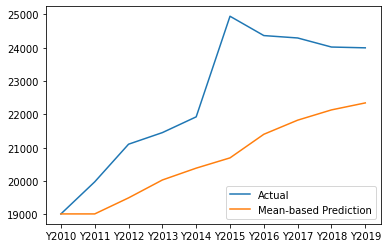

In [366]:
plt.plot(losses.index,losses["Actual"])
plt.plot(losses.index,losses.MeanBasedPred)
plt.legend(['Actual', 'Mean-based Prediction'], loc='lower right')

In [195]:
population=df[df["Element"]=="Total Population - Both sexes"]
population=population[population.Area=="China"].iloc[0,4:]*1000
population

Y2010    1399503000.0
Y2011    1407325000.0
Y2012    1415164000.0
Y2013    1422971000.0
Y2014    1430671000.0
Y2015    1438193000.0
Y2016    1445524000.0
Y2017    1452626000.0
Y2018    1459378000.0
Y2019    1465634000.0
Name: 44928, dtype: object

In [196]:
data

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
44939,China,Cereals - Excluding Beer,Production,1000 tonnes,498113.00,521383.00,541368.00,554623.00,559483.00,620074.00,616491.00,616130.00,611244.00,614914.00
44940,China,Cereals - Excluding Beer,Import Quantity,1000 tonnes,13861.00,13044.00,22636.00,22952.00,28186.00,41880.00,31380.00,35473.00,29491.00,27492.00
44941,China,Cereals - Excluding Beer,Stock Variation,1000 tonnes,8114.00,16754.00,34353.00,64549.00,75918.00,80210.00,44705.00,35028.00,7514.00,6019.00
44942,China,Cereals - Excluding Beer,Export Quantity,1000 tonnes,3127.00,2793.00,2456.00,2414.00,2029.00,1770.00,2323.00,3686.00,5683.00,7154.00
44943,China,Cereals - Excluding Beer,Domestic supply quantity,1000 tonnes,500734.00,514880.00,527195.00,510613.00,509722.00,579975.00,600843.00,612889.00,627539.00,629233.00
44944,China,Cereals - Excluding Beer,Feed,1000 tonnes,151931.00,158640.00,164114.00,151419.00,146148.00,188554.00,211366.00,219363.00,231253.00,232039.00
44945,China,Cereals - Excluding Beer,Seed,1000 tonnes,13242.00,13073.00,13167.00,12518.00,13292.00,13672.00,13576.00,13449.00,13225.00,12829.00
44946,China,Cereals - Excluding Beer,Losses,1000 tonnes,19013.00,19976.00,21105.00,21453.00,21926.00,24945.00,24365.00,24293.00,24021.00,23997.00
44947,China,Cereals - Excluding Beer,Processing,1000 tonnes,11574.00,12760.00,12688.00,13384.00,16191.00,15775.00,14741.00,14499.00,12829.00,12608.00
44948,China,Cereals - Excluding Beer,Other uses (non-food),1000 tonnes,28599.00,29694.00,32682.00,30592.00,28518.00,48065.00,49183.00,50367.00,52781.00,52100.00


In [197]:
lstm_data=pd.DataFrame(population)
lstm_data.columns=["Population"]

In [198]:
lstm_data["Actual Loss"]=losses["Actual"]

# LSTM MODEL

In [199]:
lstm_data

,Population,Actual Loss
Y2010,1399503000.0,19013.0
Y2011,1407325000.0,19976.0
Y2012,1415164000.0,21105.0
Y2013,1422971000.0,21453.0
Y2014,1430671000.0,21926.0
Y2015,1438193000.0,24945.0
Y2016,1445524000.0,24365.0
Y2017,1452626000.0,24293.0
Y2018,1459378000.0,24021.0
Y2019,1465634000.0,23997.0


In [200]:
# df_for_training=lstm_data[:-3].to_numpy()
# df_for_testing=lstm_data[-3:].to_numpy()

In [201]:
# scaler = MinMaxScaler(feature_range=(0,1))
# df_for_training_scaled = scaler.fit_transform(df_for_training)
# df_for_testing_scaled=scaler.transform(df_for_testing)
# type(df_for_training_scaled)

In [298]:
def df_to_X_y(df, window_size=3):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [299]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(lstm_data["Actual Loss"], WINDOW_SIZE)
X1.shape, y1.shape

((7, 3, 1), (7,))

In [300]:
X_train1, y_train1 = X1[:4], y1[:4]
X_val1, y_val1 = X1[4:6], y1[4:6]
X_test1, y_test1 = X1[6:], y1[6:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4, 3, 1), (4,), (2, 3, 1), (2,), (1, 3, 1), (1,))

In [301]:
model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

# model1.summary()

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 539266496.0000 - root_mean_squared_error: 23222.1113

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 5s 5s/step - loss: 539266496.0000 - root_mean_squared_error: 23222.1113 - val_loss: 502784384.0000 - val_root_mean_squared_error: 22422.8535
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 461843104.0000 - root_mean_squared_error: 21490.5352

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 461843104.0000 - root_mean_squared_error: 21490.5352 - val_loss: 356931456.0000 - val_root_mean_squared_error: 18892.6289
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 322943200.0000 - root_mean_squared_error: 17970.6211

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 4s 4s/step - loss: 322943200.0000 - root_mean_squared_error: 17970.6211 - val_loss: 157081856.0000 - val_root_mean_squared_error: 12533.2305
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 135618912.0000 - root_mean_squared_error: 11645.5537

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 135618912.0000 - root_mean_squared_error: 11645.5537 - val_loss: 9205042.0000 - val_root_mean_squared_error: 3033.9812
Epoch 5/20
1/1 [==============================] - 0s 24ms/step - loss: 6455423.0000 - root_mean_squared_error: 2540.7524 - val_loss: 68147816.0000 - val_root_mean_squared_error: 8255.1689
Epoch 6/20
1/1 [==============================] - 0s 23ms/step - loss: 87623968.0000 - root_mean_squared_error: 9360.7676 - val_loss: 137850224.0000 - val_root_mean_squared_error: 11740.9639
Epoch 7/20
1/1 [==============================] - 0s 24ms/step - loss: 164192288.0000 - root_mean_squared_error: 12813.7539 - val_loss: 76446800.0000 - val_root_mean_squared_error: 8743.3857
Epoch 8/20
1/1 [==============================] - 0s 23ms/step - loss: 96884608.0000 - root_mean_squared_error: 9842.9980 - val_loss: 11378371.0000 - val_root_mean_squared_error: 3373.1841
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 21236256.0000 - root_mean_squared_error: 4608.2812 - val_loss: 4082704.7500 - val_root_mean_squared_error: 2020.5704
Epoch 10/20
1/1 [==============================] - 0s 25ms/step - loss: 3332012.0000 - root_mean_squared_error: 1825.3800 - val_loss: 37483920.0000 - val_root_mean_squared_error: 6122.4111
Epoch 11/20
1/1 [==============================] - 0s 23ms/step - loss: 28648584.0000 - root_mean_squared_error: 5352.4370 - val_loss: 73489528.0000 - val_root_mean_squared_error: 8572.6035
Epoch 12/20
1/1 [==============================] - 0s 23ms/step - loss: 59827708.0000 - root_mean_squared_error: 7734.8374 - val_loss: 90422384.0000 - val_root_mean_squared_error: 9509.0684
Epoch 13/20
1/1 [==============================] - 0s 23ms/step - loss: 74915984.0000 - root_mean_squared_error: 8655.4023 - val_loss: 84042480.0000 - val_root_mean_squared_error: 9167.4688
Epoch 14/20
1/1 [==============================] - 0s 23ms/step - 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 4054911.0000 - root_mean_squared_error: 2013.6809 - val_loss: 847108.0000 - val_root_mean_squared_error: 920.3847
Epoch 18/20
1/1 [==============================] - 0s 31ms/step - loss: 5859707.0000 - root_mean_squared_error: 2420.6831 - val_loss: 12840812.0000 - val_root_mean_squared_error: 3583.4080
Epoch 19/20
1/1 [==============================] - 0s 29ms/step - loss: 23113050.0000 - root_mean_squared_error: 4807.6035 - val_loss: 24207910.0000 - val_root_mean_squared_error: 4920.1533
Epoch 20/20
1/1 [==============================] - 0s 33ms/step - loss: 37114272.0000 - root_mean_squared_error: 6092.1484 - val_loss: 21228370.0000 - val_root_mean_squared_error: 4607.4253


In [302]:
# from sklearn.metrics import mean_absolute_error

# parameters = {'learning_rate':(0.001,0.01,0.1,1,10,100), 'optimizer':('Adam')}
# model1_params = GridSearchCV(model1, parameters)
# model1_params.fit(X_train1, y_train1,scoring=accuracy)

In [303]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [304]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1/1 [==============================] - 0s 361ms/step


,Train Predictions,Actuals
0,25067.28125,21453.0
1,25067.28125,21926.0
2,25067.28125,24945.0
3,25067.28125,24365.0


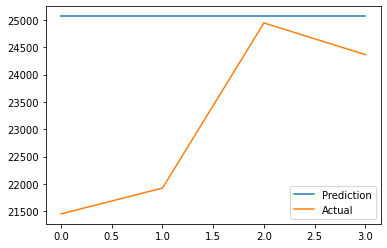

In [306]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='lower right')

In [307]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,25067.28125,24293.0
1,25067.28125,24021.0


In [308]:
# plt.plot(val_results['Val Predictions'])
# plt.plot(val_results['Actuals'])

In [309]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1/1 [==============================] - 0s 19ms/step


,Test Predictions,Actuals
0,25067.283203,23997.0


# SECOND PART

In [212]:
# from sklearn.metrics import mean_squared_error as mse

# def plot_predictions1(model, X, y, start=0, end=100):
#   predictions = model.predict(X).flatten()
#   df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
#   plt.plot(df['Predictions'])
#   plt.plot(df['Actuals'])
#   return df, mse(y, predictions)

In [213]:
# plot_predictions1(model1, X_test1, y_test1)

In [313]:
model2 = Sequential()
model2.add(InputLayer((3, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 64)             192       
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 8)                 1032      
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


In [314]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

In [315]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 685783936.0000 - root_mean_squared_error: 26187.4766

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 876ms/step - loss: 685783936.0000 - root_mean_squared_error: 26187.4766 - val_loss: 459245287999799296.0000 - val_root_mean_squared_error: 677676416.0000
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 352321252532158464.0000 - root_mean_squared_error: 593566528.0000 - val_loss: 65852522156806635520.0000 - val_root_mean_squared_error: 8114956800.0000
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 50557594134814654464.0000 - root_mean_squared_error: 7110386176.0000 - val_loss: 2391334840940068077568.0000 - val_root_mean_squared_error: 48901275648.0000
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 1835677904165329174528.0000 - root_mean_squared_error: 42844811264.0000 - val_loss: 184608477292613599232.0000 - val_root_mean_squared_error: 13587069952.0000
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - loss: 141714320873723265024.0000 - root_mean_squared_er

In [316]:
model2 = load_model('model2/')
train_predictions2 = model2.predict(X_train1).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train1})
train_results2

1/1 [==============================] - 0s 45ms/step


,Train Predictions,Actuals
0,558774080.0,21453.0
1,583779648.0,21926.0
2,599918144.0,24945.0
3,629655808.0,24365.0


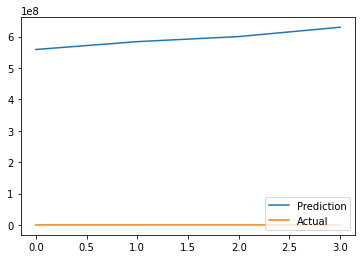

In [317]:
plt.plot(train_results2['Train Predictions'])
plt.plot(train_results2['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='lower right')

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


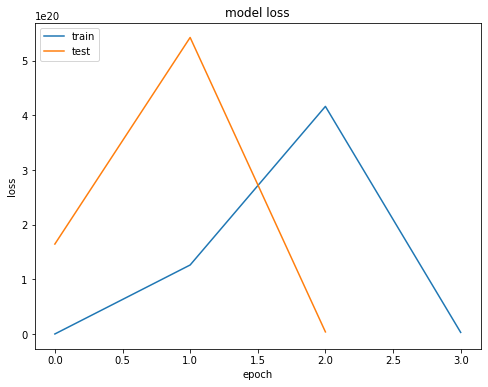

In [318]:
history = model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, verbose=0)  #..., callbacks=[cp2], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [319]:
val_predictions2 = model2.predict(X_val1).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val1})
val_results2

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,NaN,24293.0
1,NaN,24021.0


In [320]:
test_predictions2 = model2.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test1})
test_results2

1/1 [==============================] - 0s 19ms/step


,Test Predictions,Actuals
0,NaN,23997.0


# MODEL 3

In [323]:
model3 = Sequential()
model3.add(InputLayer((3, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 64)                12864     
                                                                 
 dense_40 (Dense)            (None, 8)                 520       
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [324]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1), metrics=[RootMeanSquaredError()])

In [325]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp3])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 539265792.0000 - root_mean_squared_error: 23222.0977

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 539265792.0000 - root_mean_squared_error: 23222.0977 - val_loss: 579456768.0000 - val_root_mean_squared_error: 24071.9082
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 535267680.0000 - root_mean_squared_error: 23135.8535

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 535267680.0000 - root_mean_squared_error: 23135.8535 - val_loss: 571246464.0000 - val_root_mean_squared_error: 23900.7637
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 527394496.0000 - root_mean_squared_error: 22965.0703

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 527394496.0000 - root_mean_squared_error: 22965.0703 - val_loss: 557285760.0000 - val_root_mean_squared_error: 23606.9004
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 514012480.0000 - root_mean_squared_error: 22671.8438

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 5s 5s/step - loss: 514012480.0000 - root_mean_squared_error: 22671.8438 - val_loss: 537423104.0000 - val_root_mean_squared_error: 23182.3887
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 494985952.0000 - root_mean_squared_error: 22248.2793

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 494985952.0000 - root_mean_squared_error: 22248.2793 - val_loss: 511654016.0000 - val_root_mean_squared_error: 22619.7695
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 470324992.0000 - root_mean_squared_error: 21686.9766

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 470324992.0000 - root_mean_squared_error: 21686.9766 - val_loss: 480116992.0000 - val_root_mean_squared_error: 21911.5723
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 440182784.0000 - root_mean_squared_error: 20980.5332

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 440182784.0000 - root_mean_squared_error: 20980.5332 - val_loss: 443116224.0000 - val_root_mean_squared_error: 21050.3262
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 404878272.0000 - root_mean_squared_error: 20121.5879

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 404878272.0000 - root_mean_squared_error: 20121.5879 - val_loss: 401147328.0000 - val_root_mean_squared_error: 20028.6621
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 364921600.0000 - root_mean_squared_error: 19102.9219

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 364921600.0000 - root_mean_squared_error: 19102.9219 - val_loss: 354927968.0000 - val_root_mean_squared_error: 18839.5312
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 321044288.0000 - root_mean_squared_error: 17917.7090

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 321044288.0000 - root_mean_squared_error: 17917.7090 - val_loss: 305427584.0000 - val_root_mean_squared_error: 17476.4863
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 274228480.0000 - root_mean_squared_error: 16559.8457

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 274228480.0000 - root_mean_squared_error: 16559.8457 - val_loss: 253898688.0000 - val_root_mean_squared_error: 15934.1982
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 225737216.0000 - root_mean_squared_error: 15024.5537

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 225737216.0000 - root_mean_squared_error: 15024.5537 - val_loss: 201902112.0000 - val_root_mean_squared_error: 14209.2266
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 177138112.0000 - root_mean_squared_error: 13309.3242

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 177138112.0000 - root_mean_squared_error: 13309.3242 - val_loss: 151322624.0000 - val_root_mean_squared_error: 12301.3262
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 130316448.0000 - root_mean_squared_error: 11415.6230

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 130316448.0000 - root_mean_squared_error: 11415.6230 - val_loss: 104357664.0000 - val_root_mean_squared_error: 10215.5596
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 87459696.0000 - root_mean_squared_error: 9351.9893

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 87459696.0000 - root_mean_squared_error: 9351.9893 - val_loss: 63454072.0000 - val_root_mean_squared_error: 7965.8066
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 50987504.0000 - root_mean_squared_error: 7140.5537

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 50987504.0000 - root_mean_squared_error: 7140.5537 - val_loss: 31140708.0000 - val_root_mean_squared_error: 5580.3862
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 23373202.0000 - root_mean_squared_error: 4834.5840

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 23373202.0000 - root_mean_squared_error: 4834.5840 - val_loss: 9676873.0000 - val_root_mean_squared_error: 3110.7673
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 6775875.0000 - root_mean_squared_error: 2603.0510

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 6775875.0000 - root_mean_squared_error: 2603.0510 - val_loss: 423106.3125 - val_root_mean_squared_error: 650.4662
Epoch 19/100
1/1 [==============================] - 0s 22ms/step - loss: 2390127.5000 - root_mean_squared_error: 1546.0037 - val_loss: 2944219.5000 - val_root_mean_squared_error: 1715.8728
Epoch 20/100
1/1 [==============================] - 0s 23ms/step - loss: 9532800.0000 - root_mean_squared_error: 3087.5232 - val_loss: 14235328.0000 - val_root_mean_squared_error: 3772.9734
Epoch 21/100
1/1 [==============================] - 0s 23ms/step - loss: 24881170.0000 - root_mean_squared_error: 4988.1030 - val_loss: 28975570.0000 - val_root_mean_squared_error: 5382.8960
Epoch 22/100
1/1 [==============================] - 0s 23ms/step - loss: 42793600.0000 - root_mean_squared_error: 6541.6816 - val_loss: 41372440.0000 - val_root_mean_squared_error: 6432.1411
Epoch 23/100
1/1 [==============================] - 0s 24ms/step - 

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 9648096.0000 - root_mean_squared_error: 3106.1384 - val_loss: 215243.6875 - val_root_mean_squared_error: 463.9436
Epoch 31/100
1/1 [==============================] - 0s 22ms/step - loss: 4308640.0000 - root_mean_squared_error: 2075.7263 - val_loss: 604501.1875 - val_root_mean_squared_error: 777.4968
Epoch 32/100
1/1 [==============================] - 0s 22ms/step - loss: 2316630.0000 - root_mean_squared_error: 1522.0480 - val_loss: 3441169.5000 - val_root_mean_squared_error: 1855.0389
Epoch 33/100
1/1 [==============================] - 0s 22ms/step - loss: 3017302.2500 - root_mean_squared_error: 1737.0383 - val_loss: 7739047.0000 - val_root_mean_squared_error: 2781.9143
Epoch 34/100
1/1 [==============================] - 0s 22ms/step - loss: 5486418.0000 - root_mean_squared_error: 2342.3103 - val_loss: 12495038.0000 - val_root_mean_squared_error: 3534.8320
Epoch 35/100
1/1 [==============================] - 0s 22ms/step - loss: 

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 2377494.5000 - root_mean_squared_error: 1541.9126 - val_loss: 41428.7266 - val_root_mean_squared_error: 203.5405
Epoch 49/100
1/1 [==============================] - 0s 23ms/step - loss: 2962976.7500 - root_mean_squared_error: 1721.3300 - val_loss: 88963.4375 - val_root_mean_squared_error: 298.2674
Epoch 50/100
1/1 [==============================] - 0s 22ms/step - loss: 3831581.2500 - root_mean_squared_error: 1957.4425 - val_loss: 352514.5312 - val_root_mean_squared_error: 593.7294
Epoch 51/100
1/1 [==============================] - 0s 23ms/step - loss: 4710574.5000 - root_mean_squared_error: 2170.3857 - val_loss: 619248.1250 - val_root_mean_squared_error: 786.9232
Epoch 52/100
1/1 [==============================] - 0s 23ms/step - loss: 5365572.5000 - root_mean_squared_error: 2316.3706 - val_loss: 747595.1875 - val_root_mean_squared_error: 864.6359
Epoch 53/100
1/1 [==============================] - 0s 23ms/step - loss: 5649098.5

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 3626485.0000 - root_mean_squared_error: 1904.3333 - val_loss: 38585.1875 - val_root_mean_squared_error: 196.4311
Epoch 58/100
1/1 [==============================] - 0s 22ms/step - loss: 2979235.5000 - root_mean_squared_error: 1726.0463 - val_loss: 249609.0625 - val_root_mean_squared_error: 499.6089
Epoch 59/100
1/1 [==============================] - 0s 22ms/step - loss: 2522587.5000 - root_mean_squared_error: 1588.2655 - val_loss: 682883.3750 - val_root_mean_squared_error: 826.3676
Epoch 60/100
1/1 [==============================] - 0s 22ms/step - loss: 2297345.0000 - root_mean_squared_error: 1515.6995 - val_loss: 1286671.1250 - val_root_mean_squared_error: 1134.3153
Epoch 61/100
1/1 [==============================] - 0s 23ms/step - loss: 2288552.7500 - root_mean_squared_error: 1512.7964 - val_loss: 1974615.1250 - val_root_mean_squared_error: 1405.2100
Epoch 62/100
1/1 [==============================] - 0s 22ms/step - loss: 2439

In [326]:
model3 = load_model('model3/')
train_predictions3 = model3.predict(X_train1).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train1})
train_results3

1/1 [==============================] - 0s 275ms/step


,Train Predictions,Actuals
0,24015.263672,21453.0
1,24015.263672,21926.0
2,24015.263672,24945.0
3,24015.263672,24365.0


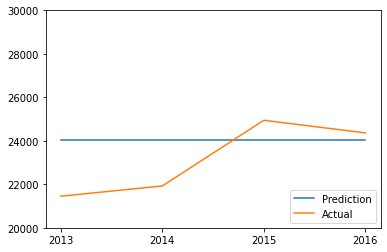

In [332]:
train_results3.index=['2013','2014','2015','2016']
plt.plot(train_results3['Train Predictions'])
plt.plot(train_results3['Actuals'])

plt.legend(['Prediction', 'Actual'], loc='lower right')
plt.ylim(20000,30000)
ax = plt.gca()
# ax.invert_xaxis()

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


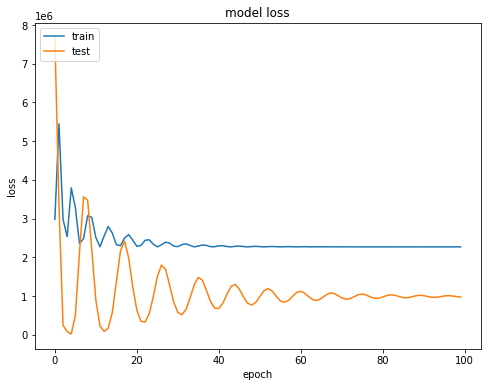

In [330]:
history = model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp3], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [333]:
val_predictions3 = model3.predict(X_val1).flatten()
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val1})
val_results3

1/1 [==============================] - 0s 18ms/step


,Val Predictions,Actuals
0,23180.671875,24293.0
1,23180.671875,24021.0


In [334]:
test_predictions3 = model3.predict(X_test1).flatten()
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test1})
test_results3

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,23180.673828,23997.0


In [345]:
lstm_data["Actual Loss"][:3].values

array([19013, 19976, 21105])

In [351]:
# lstm_data["Actual Loss"][:3]=tf.convert_to_tensor(lstm_data["Actual Loss"][:3], dtype=tf.int64)
final_predictions=model3.predict([24159,24523,23435]).flatten()
final_result=pd.DataFrame(data={'Predictions':final_predictions, 'Actuals':[24159,24523,23435]})

2022-07-19 21:45:21.238740: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 1. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 1. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_20/gru_5/PartitionedCall]] [Op:__inference_predict_function_2784537]

In [339]:
final_result

,Predictions,Actuals
Y2010,23180.671875,19013
Y2011,23180.671875,19976
Y2012,23180.671875,21105
Y2013,23180.671875,21453
Y2014,23180.671875,21926
Y2015,23180.671875,24945
Y2016,23180.671875,24365
Y2017,23180.671875,24293
Y2018,23180.671875,24021
Y2019,23180.671875,23997


# Multi-variate Dataset

In [230]:
def df_to_X_y2(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [231]:
X2, y2 = df_to_X_y2(lstm_data)
X2.shape, y2.shape

((5, 5, 2), (5,))

In [232]:
# loss_training_mean = np.mean(X_train2[:, :, 1])
# loss_training_std = np.std(X_train2[:, :, 1])
                           
# def preprocess_loss(X):
#   X[:, :, 1] = (X[:, :, 1] - loss_training_mean) / loss_training_std
#   return X

# pop_training_mean = np.mean(X_train2[:, :, 0])
# pop_training_std = np.std(X_train2[:, :, 0])
                           
# def preprocess_pop(X):
#   X[:, :, 0] = (X[:, :, 0] - pop_training_mean) / pop_training_std
#   return X

loss_mean = np.mean(X2[:, :, 1])
loss_std = np.std(X2[:, :, 1])
                           
def preprocess_loss(X):
  X[:, :, 1] = (X[:, :, 1] - loss_mean) / loss_std
  return X

pop_mean = np.mean(X_train2[:, :, 0])
pop_std = np.std(X_train2[:, :, 0])
                           
def preprocess_pop(X):
  X[:, :, 0] = (X[:, :, 0] - pop_mean) / pop_std
  return X

In [233]:
# preprocess_loss(X_train2)
# preprocess_loss(X_val2)
# preprocess_loss(X_test2)
# preprocess_pop(X_train2)
# preprocess_pop(X_val2)
# preprocess_pop(X_test2)
X2=X2[:]
preprocess_loss(X2)
preprocess_pop(X2)

array([[[2212808536.1193137, -1.9669935250211181],
        [2225176204.048232, -1.4281233840900263],
        [2237570751.337262, -0.7963638938395562],
        [2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703]],

       [[2225176204.048232, -1.4281233840900263],
        [2237570751.337262, -0.7963638938395562],
        [2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703],
        [2273982797.455271, 1.3524017771629284]],

       [[2237570751.337262, -0.7963638938395562],
        [2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703],
        [2273982797.455271, 1.3524017771629284],
        [2285574126.218618, 1.0278486289385949]],

       [[2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703],
        [2273982797.455271, 1.3524017771629284],
        [2285574126.218618, 1.0278486289385949],
        [2296803374.189876, 0.98755927260729

In [234]:
X_train2, y_train2 = X2[:3], y2[:3]
X_val2, y_val2 = X2[3:4], y2[3:4]
X_test2, y_test2 = X2[4:], y2[4:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((3, 5, 2), (3,), (1, 5, 2), (1,), (1, 5, 2), (1,))

In [235]:
X_train2=tf.convert_to_tensor(X_train2, dtype=tf.int64)
y_train2=tf.convert_to_tensor(y_train2, dtype=tf.int64)
X_val2=tf.convert_to_tensor(X_val2, dtype=tf.int64)
y_val2=tf.convert_to_tensor(y_val2, dtype=tf.int64)
X_test2=tf.convert_to_tensor(X_test2, dtype=tf.int64)
y_test2=tf.convert_to_tensor(y_test2, dtype=tf.int64)


# MODEL 4

In [236]:
model4 = Sequential()
model4.add(InputLayer((5, 2)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                17152     
                                                                 
 dense_26 (Dense)            (None, 8)                 520       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [237]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=100), metrics=[RootMeanSquaredError()])

In [238]:
model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp4])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 4s 4s/step - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000 - val_loss: 2128300606069145600.0000 - val_root_mean_squared_error: 1458869632.0000
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 2087884207899541504.0000 - root_mean_squared_error: 1444951296.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2087884207899541504.0000 - root_mean_squared_error: 1444951296.0000 - val_loss: 2125273513118924800.0000 - val_root_mean_squared_error: 1457831808.0000
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 2084886252007456768.0000 - root_mean_squared_error: 1443913472.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2084886252007456768.0000 - root_mean_squared_error: 1443913472.0000 - val_loss: 2119898000770727936.0000 - val_root_mean_squared_error: 1455986944.0000
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 2079561866949951488.0000 - root_mean_squared_error: 1442068608.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 4s 4s/step - loss: 2079561866949951488.0000 - root_mean_squared_error: 1442068608.0000 - val_loss: 2112035805437362176.0000 - val_root_mean_squared_error: 1453284480.0000
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 2071774988163088384.0000 - root_mean_squared_error: 1439366144.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2071774988163088384.0000 - root_mean_squared_error: 1439366144.0000 - val_loss: 2101565018767097856.0000 - val_root_mean_squared_error: 1449677568.0000
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 2061404669367812096.0000 - root_mean_squared_error: 1435759232.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2061404669367812096.0000 - root_mean_squared_error: 1435759232.0000 - val_loss: 2088371016672739328.0000 - val_root_mean_squared_error: 1445119744.0000
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 2048337798305415168.0000 - root_mean_squared_error: 1431201536.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2048337798305415168.0000 - root_mean_squared_error: 1431201536.0000 - val_loss: 2072346871648485376.0000 - val_root_mean_squared_error: 1439564800.0000
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 2032468272103817216.0000 - root_mean_squared_error: 1425646592.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2032468272103817216.0000 - root_mean_squared_error: 1425646592.0000 - val_loss: 2053392390697254912.0000 - val_root_mean_squared_error: 1432966272.0000
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 2013697684472332288.0000 - root_mean_squared_error: 1419048192.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2013697684472332288.0000 - root_mean_squared_error: 1419048192.0000 - val_loss: 2031417276426616832.0000 - val_root_mean_squared_error: 1425277952.0000
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 1991936700091203584.0000 - root_mean_squared_error: 1411359872.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1991936700091203584.0000 - root_mean_squared_error: 1411359872.0000 - val_loss: 2006342363999371264.0000 - val_root_mean_squared_error: 1416454144.0000
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 1967107665951719424.0000 - root_mean_squared_error: 1402536192.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 4s 4s/step - loss: 1967107665951719424.0000 - root_mean_squared_error: 1402536192.0000 - val_loss: 1978098796499828736.0000 - val_root_mean_squared_error: 1406449024.0000
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 1939142824649818112.0000 - root_mean_squared_error: 1392531072.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1939142824649818112.0000 - root_mean_squared_error: 1392531072.0000 - val_loss: 1946632010663460864.0000 - val_root_mean_squared_error: 1395217536.0000
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 1907988987310505984.0000 - root_mean_squared_error: 1381299712.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1907988987310505984.0000 - root_mean_squared_error: 1381299712.0000 - val_loss: 1911901187121086464.0000 - val_root_mean_squared_error: 1382715136.0000
Epoch 14/20
1/1 [==============================] - ETA: 0s - loss: 1873606296637276160.0000 - root_mean_squared_error: 1368797440.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1873606296637276160.0000 - root_mean_squared_error: 1368797440.0000 - val_loss: 1873881449422127104.0000 - val_root_mean_squared_error: 1368897920.0000
Epoch 15/20
1/1 [==============================] - ETA: 0s - loss: 1835971800324898816.0000 - root_mean_squared_error: 1354980352.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1835971800324898816.0000 - root_mean_squared_error: 1354980352.0000 - val_loss: 1832566612813676544.0000 - val_root_mean_squared_error: 1353723264.0000
Epoch 16/20
1/1 [==============================] - ETA: 0s - loss: 1795079725937328128.0000 - root_mean_squared_error: 1339805824.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1795079725937328128.0000 - root_mean_squared_error: 1339805824.0000 - val_loss: 1787968909362593792.0000 - val_root_mean_squared_error: 1337149568.0000
Epoch 17/20
1/1 [==============================] - ETA: 0s - loss: 1750943679930957824.0000 - root_mean_squared_error: 1323232256.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1750943679930957824.0000 - root_mean_squared_error: 1323232256.0000 - val_loss: 1740121461856665600.0000 - val_root_mean_squared_error: 1319136640.0000
Epoch 18/20
1/1 [==============================] - ETA: 0s - loss: 1703598159483109376.0000 - root_mean_squared_error: 1305219584.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1703598159483109376.0000 - root_mean_squared_error: 1305219584.0000 - val_loss: 1689079933072048128.0000 - val_root_mean_squared_error: 1299646080.0000
Epoch 19/20
1/1 [==============================] - ETA: 0s - loss: 1653099652003659776.0000 - root_mean_squared_error: 1285729280.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 4s 4s/step - loss: 1653099652003659776.0000 - root_mean_squared_error: 1285729280.0000 - val_loss: 1634924175040708608.0000 - val_root_mean_squared_error: 1278641536.0000
Epoch 20/20
1/1 [==============================] - ETA: 0s - loss: 1599528971597250560.0000 - root_mean_squared_error: 1264724864.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1599528971597250560.0000 - root_mean_squared_error: 1264724864.0000 - val_loss: 1577759740878913536.0000 - val_root_mean_squared_error: 1256089088.0000


In [239]:
model4 = load_model('model4/')
train_predictions4 = model4.predict(X_train2).flatten()
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y_train2})
train_results4

1/1 [==============================] - 0s 308ms/step


,Train Predictions,Actuals
0,203289024.0,1438193000
1,203289024.0,1445524000
2,203289024.0,1452626000


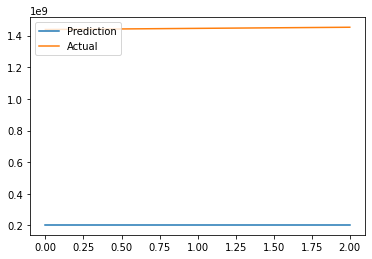

In [240]:
plt.plot(train_results4['Train Predictions'])
plt.plot(train_results4['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='upper left')

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


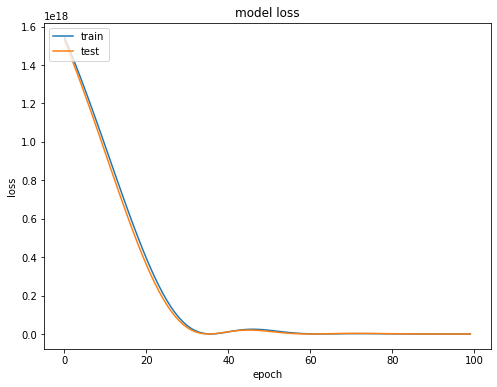

In [241]:
history = model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp4], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [242]:
val_predictions4 = model4.predict(X_val2).flatten()
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y_val2})
val_results4

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,1.456134e+09,1459378000


In [243]:
test_predictions4 = model4.predict(X_test2).flatten()
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y_test2})
test_results4

1/1 [==============================] - 0s 16ms/step


,Test Predictions,Actuals
0,1.456134e+09,1465634000


# MODEL 5

In [244]:
model5 = Sequential()
model5.add(InputLayer((5, 2)))
model5.add(Conv1D(64, kernel_size=2))
model5.add(Flatten())
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 64)             320       
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 8)                 2056      
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


In [245]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

In [246]:
model5.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp5])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2819886685431529472.0000 - root_mean_squared_error: 1679251840.0000

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1/1 [==============================] - 1s 813ms/step - loss: 2819886685431529472.0000 - root_mean_squared_error: 1679251840.0000 - val_loss: 214065414147523215360.0000 - val_root_mean_squared_error: 14630974464.0000
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: 209719950680505974784.0000 - root_mean_squared_error: 14481711104.0000 - val_loss: 2469249366293391343616.0000 - val_root_mean_squared_error: 49691541504.0000
Epoch 3/20
1/1 [==============================] - 0s 21ms/step - loss: 2416633530371845128192.0000 - root_mean_squared_error: 49159266304.0000 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/20
1/1 [==============================] - 0s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/20
1/1 [==============================] - 0s 21ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/20
1/1 [==============================

In [247]:
model5 = load_model('model5/')
train_predictions5 = model5.predict(X_train2).flatten()
train_results5 = pd.DataFrame(data={'Train Predictions':train_predictions5, 'Actuals':y_train2})
train_results5

1/1 [==============================] - 0s 43ms/step


,Train Predictions,Actuals
0,-1.296720e+10,1438193000
1,-1.303647e+10,1445524000
2,-1.310473e+10,1452626000


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


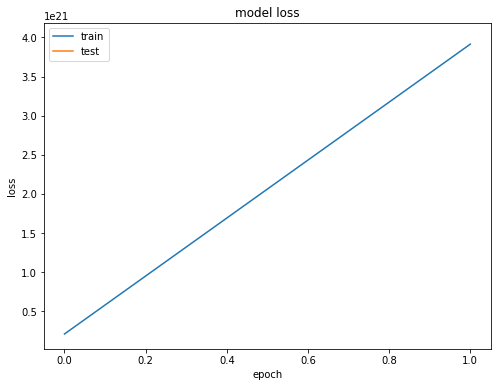

In [248]:
history = model5.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200, callbacks=[cp5], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# MODEL 6

In [249]:
model6 = Sequential()
model6.add(InputLayer((5, 2)))
model6.add(GRU(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                13056     
                                                                 
 dense_30 (Dense)            (None, 8)                 520       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,585
Trainable params: 13,585
Non-trainable params: 0
_________________________________________________________________


In [250]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1), metrics=[RootMeanSquaredError()])

In [251]:
model6.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp6])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000 - val_loss: 2129784259571875840.0000 - val_root_mean_squared_error: 1459378048.0000
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000 - val_loss: 2129783847255015424.0000 - val_root_mean_squared_error: 1459377920.0000
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 2089353430312157184.0000 - root_mean_squared_error: 1445459584.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089353430312157184.0000 - root_mean_squared_error: 1445459584.0000 - val_loss: 2129783572377108480.0000 - val_root_mean_squared_error: 1459377792.0000
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 2089353017995296768.0000 - root_mean_squared_error: 1445459456.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089353017995296768.0000 - root_mean_squared_error: 1445459456.0000 - val_loss: 2129782747743387648.0000 - val_root_mean_squared_error: 1459377536.0000
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 2089352330800529408.0000 - root_mean_squared_error: 1445459200.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089352330800529408.0000 - root_mean_squared_error: 1445459200.0000 - val_loss: 2129782060548620288.0000 - val_root_mean_squared_error: 1459377280.0000
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 2089351506166808576.0000 - root_mean_squared_error: 1445458944.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089351506166808576.0000 - root_mean_squared_error: 1445458944.0000 - val_loss: 2129780961036992512.0000 - val_root_mean_squared_error: 1459376896.0000
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 2089350406655180800.0000 - root_mean_squared_error: 1445458560.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089350406655180800.0000 - root_mean_squared_error: 1445458560.0000 - val_loss: 2129779861525364736.0000 - val_root_mean_squared_error: 1459376512.0000
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 2089349307143553024.0000 - root_mean_squared_error: 1445458176.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089349307143553024.0000 - root_mean_squared_error: 1445458176.0000 - val_loss: 2129778349696876544.0000 - val_root_mean_squared_error: 1459376000.0000
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 2089347657876111360.0000 - root_mean_squared_error: 1445457536.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2089347657876111360.0000 - root_mean_squared_error: 1445457536.0000 - val_loss: 2129776425551527936.0000 - val_root_mean_squared_error: 1459375360.0000
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 2089345871169716224.0000 - root_mean_squared_error: 1445457024.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089345871169716224.0000 - root_mean_squared_error: 1445457024.0000 - val_loss: 2129774638845132800.0000 - val_root_mean_squared_error: 1459374720.0000
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 2089344084463321088.0000 - root_mean_squared_error: 1445456384.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089344084463321088.0000 - root_mean_squared_error: 1445456384.0000 - val_loss: 2129772714699784192.0000 - val_root_mean_squared_error: 1459374080.0000
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 2089342160317972480.0000 - root_mean_squared_error: 1445455744.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089342160317972480.0000 - root_mean_squared_error: 1445455744.0000 - val_loss: 2129770103359668224.0000 - val_root_mean_squared_error: 1459373184.0000
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 2089339686416809984.0000 - root_mean_squared_error: 1445454848.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089339686416809984.0000 - root_mean_squared_error: 1445454848.0000 - val_loss: 2129767492019552256.0000 - val_root_mean_squared_error: 1459372288.0000
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 2089337075076694016.0000 - root_mean_squared_error: 1445453952.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089337075076694016.0000 - root_mean_squared_error: 1445453952.0000 - val_loss: 2129764468362575872.0000 - val_root_mean_squared_error: 1459371264.0000
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 2089334188858671104.0000 - root_mean_squared_error: 1445452928.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089334188858671104.0000 - root_mean_squared_error: 1445452928.0000 - val_loss: 2129761169827692544.0000 - val_root_mean_squared_error: 1459370112.0000
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 2089330890323787776.0000 - root_mean_squared_error: 1445451776.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089330890323787776.0000 - root_mean_squared_error: 1445451776.0000 - val_loss: 2129757733853855744.0000 - val_root_mean_squared_error: 1459368960.0000
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 2089327316910997504.0000 - root_mean_squared_error: 1445450496.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089327316910997504.0000 - root_mean_squared_error: 1445450496.0000 - val_loss: 2129754023002112000.0000 - val_root_mean_squared_error: 1459367680.0000
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 2089323880937160704.0000 - root_mean_squared_error: 1445449344.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2089323880937160704.0000 - root_mean_squared_error: 1445449344.0000 - val_loss: 2129749899833507840.0000 - val_root_mean_squared_error: 1459366272.0000
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 2089319620329603072.0000 - root_mean_squared_error: 1445447936.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089319620329603072.0000 - root_mean_squared_error: 1445447936.0000 - val_loss: 2129745364348043264.0000 - val_root_mean_squared_error: 1459364736.0000
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 2089315222283091968.0000 - root_mean_squared_error: 1445446400.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089315222283091968.0000 - root_mean_squared_error: 1445446400.0000 - val_loss: 2129740553984671744.0000 - val_root_mean_squared_error: 1459363072.0000
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 2089310549358673920.0000 - root_mean_squared_error: 1445444736.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089310549358673920.0000 - root_mean_squared_error: 1445444736.0000 - val_loss: 2129735331304439808.0000 - val_root_mean_squared_error: 1459361280.0000
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 2089305189239488512.0000 - root_mean_squared_error: 1445442944.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089305189239488512.0000 - root_mean_squared_error: 1445442944.0000 - val_loss: 2129729696307347456.0000 - val_root_mean_squared_error: 1459359360.0000
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 2089299691681349632.0000 - root_mean_squared_error: 1445441024.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089299691681349632.0000 - root_mean_squared_error: 1445441024.0000 - val_loss: 2129724198749208576.0000 - val_root_mean_squared_error: 1459357440.0000
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 2089294194123210752.0000 - root_mean_squared_error: 1445439104.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089294194123210752.0000 - root_mean_squared_error: 1445439104.0000 - val_loss: 2129717739118395392.0000 - val_root_mean_squared_error: 1459355264.0000
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 2089288009370304512.0000 - root_mean_squared_error: 1445436928.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089288009370304512.0000 - root_mean_squared_error: 1445436928.0000 - val_loss: 2129711416926535680.0000 - val_root_mean_squared_error: 1459353088.0000
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 2089281549739491328.0000 - root_mean_squared_error: 1445434752.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089281549739491328.0000 - root_mean_squared_error: 1445434752.0000 - val_loss: 2129704270100955136.0000 - val_root_mean_squared_error: 1459350656.0000
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 2089274402913910784.0000 - root_mean_squared_error: 1445432192.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2089274402913910784.0000 - root_mean_squared_error: 1445432192.0000 - val_loss: 2129697260714328064.0000 - val_root_mean_squared_error: 1459348224.0000
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 2089267668405190656.0000 - root_mean_squared_error: 1445429888.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089267668405190656.0000 - root_mean_squared_error: 1445429888.0000 - val_loss: 2129689426693980160.0000 - val_root_mean_squared_error: 1459345536.0000
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 2089259696945889280.0000 - root_mean_squared_error: 1445427200.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089259696945889280.0000 - root_mean_squared_error: 1445427200.0000 - val_loss: 2129681180356771840.0000 - val_root_mean_squared_error: 1459342720.0000
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 2089251725486587904.0000 - root_mean_squared_error: 1445424384.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089251725486587904.0000 - root_mean_squared_error: 1445424384.0000 - val_loss: 2129672521702703104.0000 - val_root_mean_squared_error: 1459339776.0000
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 2089243066832519168.0000 - root_mean_squared_error: 1445421440.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089243066832519168.0000 - root_mean_squared_error: 1445421440.0000 - val_loss: 2129663588170727424.0000 - val_root_mean_squared_error: 1459336704.0000
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 2089234133300543488.0000 - root_mean_squared_error: 1445418368.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089234133300543488.0000 - root_mean_squared_error: 1445418368.0000 - val_loss: 2129654242321891328.0000 - val_root_mean_squared_error: 1459333504.0000
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 2089224924890660864.0000 - root_mean_squared_error: 1445415168.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089224924890660864.0000 - root_mean_squared_error: 1445415168.0000 - val_loss: 2129644621595148288.0000 - val_root_mean_squared_error: 1459330176.0000
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 2089215441602871296.0000 - root_mean_squared_error: 1445411840.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089215441602871296.0000 - root_mean_squared_error: 1445411840.0000 - val_loss: 2129634451112591360.0000 - val_root_mean_squared_error: 1459326720.0000
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 2089205271120314368.0000 - root_mean_squared_error: 1445408384.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089205271120314368.0000 - root_mean_squared_error: 1445408384.0000 - val_loss: 2129623593435267072.0000 - val_root_mean_squared_error: 1459323008.0000
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 2089194688320897024.0000 - root_mean_squared_error: 1445404672.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089194688320897024.0000 - root_mean_squared_error: 1445404672.0000 - val_loss: 2129612873196896256.0000 - val_root_mean_squared_error: 1459319296.0000
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 2089183830643572736.0000 - root_mean_squared_error: 1445400960.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2089183830643572736.0000 - root_mean_squared_error: 1445400960.0000 - val_loss: 2129601190885851136.0000 - val_root_mean_squared_error: 1459315328.0000
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 2089172560649388032.0000 - root_mean_squared_error: 1445396992.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089172560649388032.0000 - root_mean_squared_error: 1445396992.0000 - val_loss: 2129588958818992128.0000 - val_root_mean_squared_error: 1459311104.0000
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 2089160191143575552.0000 - root_mean_squared_error: 1445392768.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089160191143575552.0000 - root_mean_squared_error: 1445392768.0000 - val_loss: 2129576589313179648.0000 - val_root_mean_squared_error: 1459306880.0000
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 2089147959076716544.0000 - root_mean_squared_error: 1445388544.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089147959076716544.0000 - root_mean_squared_error: 1445388544.0000 - val_loss: 2129563532612599808.0000 - val_root_mean_squared_error: 1459302400.0000
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 2089135177254043648.0000 - root_mean_squared_error: 1445384064.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089135177254043648.0000 - root_mean_squared_error: 1445384064.0000 - val_loss: 2129550063595159552.0000 - val_root_mean_squared_error: 1459297792.0000
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 2089121708236603392.0000 - root_mean_squared_error: 1445379456.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089121708236603392.0000 - root_mean_squared_error: 1445379456.0000 - val_loss: 2129536182260858880.0000 - val_root_mean_squared_error: 1459293056.0000
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 2089107964341256192.0000 - root_mean_squared_error: 1445374720.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089107964341256192.0000 - root_mean_squared_error: 1445374720.0000 - val_loss: 2129522026048651264.0000 - val_root_mean_squared_error: 1459288192.0000
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 2089094083006955520.0000 - root_mean_squared_error: 1445369856.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089094083006955520.0000 - root_mean_squared_error: 1445369856.0000 - val_loss: 2129507045202722816.0000 - val_root_mean_squared_error: 1459283072.0000
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 2089079102161027072.0000 - root_mean_squared_error: 1445364736.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089079102161027072.0000 - root_mean_squared_error: 1445364736.0000 - val_loss: 2129491789478887424.0000 - val_root_mean_squared_error: 1459277824.0000
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 2089063983876145152.0000 - root_mean_squared_error: 1445359488.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2089063983876145152.0000 - root_mean_squared_error: 1445359488.0000 - val_loss: 2129475709121331200.0000 - val_root_mean_squared_error: 1459272320.0000
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 2089048040957542400.0000 - root_mean_squared_error: 1445353984.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2089048040957542400.0000 - root_mean_squared_error: 1445353984.0000 - val_loss: 2129459216446914560.0000 - val_root_mean_squared_error: 1459266688.0000
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 2089031823161032704.0000 - root_mean_squared_error: 1445348352.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089031823161032704.0000 - root_mean_squared_error: 1445348352.0000 - val_loss: 2129442448894590976.0000 - val_root_mean_squared_error: 1459260928.0000
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 2089015330486616064.0000 - root_mean_squared_error: 1445342592.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2089015330486616064.0000 - root_mean_squared_error: 1445342592.0000 - val_loss: 2129424856708546560.0000 - val_root_mean_squared_error: 1459254912.0000
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 2088997738300571648.0000 - root_mean_squared_error: 1445336576.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088997738300571648.0000 - root_mean_squared_error: 1445336576.0000 - val_loss: 2129406989644595200.0000 - val_root_mean_squared_error: 1459248768.0000
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 2088980146114527232.0000 - root_mean_squared_error: 1445330432.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088980146114527232.0000 - root_mean_squared_error: 1445330432.0000 - val_loss: 2129388710263783424.0000 - val_root_mean_squared_error: 1459242496.0000
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 2088961729294761984.0000 - root_mean_squared_error: 1445324032.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088961729294761984.0000 - root_mean_squared_error: 1445324032.0000 - val_loss: 2129369606249250816.0000 - val_root_mean_squared_error: 1459235968.0000
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 2088942900158136320.0000 - root_mean_squared_error: 1445317632.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088942900158136320.0000 - root_mean_squared_error: 1445317632.0000 - val_loss: 2129350227356811264.0000 - val_root_mean_squared_error: 1459229312.0000
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 2088923658704650240.0000 - root_mean_squared_error: 1445310976.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088923658704650240.0000 - root_mean_squared_error: 1445310976.0000 - val_loss: 2129330023830650880.0000 - val_root_mean_squared_error: 1459222400.0000
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 2088903730056396800.0000 - root_mean_squared_error: 1445304064.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088903730056396800.0000 - root_mean_squared_error: 1445304064.0000 - val_loss: 2129309407987630080.0000 - val_root_mean_squared_error: 1459215360.0000
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 2088883526530236416.0000 - root_mean_squared_error: 1445297024.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2088883526530236416.0000 - root_mean_squared_error: 1445297024.0000 - val_loss: 2129288517266702336.0000 - val_root_mean_squared_error: 1459208192.0000
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 2088862635809308672.0000 - root_mean_squared_error: 1445289856.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088862635809308672.0000 - root_mean_squared_error: 1445289856.0000 - val_loss: 2129266939351007232.0000 - val_root_mean_squared_error: 1459200768.0000
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 2088841195332567040.0000 - root_mean_squared_error: 1445282432.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088841195332567040.0000 - root_mean_squared_error: 1445282432.0000 - val_loss: 2129244399362637824.0000 - val_root_mean_squared_error: 1459193088.0000
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 2088819067661058048.0000 - root_mean_squared_error: 1445274752.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088819067661058048.0000 - root_mean_squared_error: 1445274752.0000 - val_loss: 2129221721935314944.0000 - val_root_mean_squared_error: 1459185280.0000
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 2088796527672688640.0000 - root_mean_squared_error: 1445266944.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088796527672688640.0000 - root_mean_squared_error: 1445266944.0000 - val_loss: 2129198494752178176.0000 - val_root_mean_squared_error: 1459177344.0000
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 2088773575367458816.0000 - root_mean_squared_error: 1445259008.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 3s 3s/step - loss: 2088773575367458816.0000 - root_mean_squared_error: 1445259008.0000 - val_loss: 2129174580374274048.0000 - val_root_mean_squared_error: 1459169152.0000
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 2088749935867461632.0000 - root_mean_squared_error: 1445250816.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088749935867461632.0000 - root_mean_squared_error: 1445250816.0000 - val_loss: 2129150391118462976.0000 - val_root_mean_squared_error: 1459160832.0000
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 2088725746611650560.0000 - root_mean_squared_error: 1445242496.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088725746611650560.0000 - root_mean_squared_error: 1445242496.0000 - val_loss: 2129125239789977600.0000 - val_root_mean_squared_error: 1459152256.0000
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 2088701007600025600.0000 - root_mean_squared_error: 1445233920.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088701007600025600.0000 - root_mean_squared_error: 1445233920.0000 - val_loss: 2129099951022538752.0000 - val_root_mean_squared_error: 1459143552.0000
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 2088675856271540224.0000 - root_mean_squared_error: 1445225216.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2088675856271540224.0000 - root_mean_squared_error: 1445225216.0000 - val_loss: 2129073700182425600.0000 - val_root_mean_squared_error: 1459134592.0000
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 2088649880309334016.0000 - root_mean_squared_error: 1445216256.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088649880309334016.0000 - root_mean_squared_error: 1445216256.0000 - val_loss: 2129047174464405504.0000 - val_root_mean_squared_error: 1459125504.0000
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 2088623629469220864.0000 - root_mean_squared_error: 1445207168.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088623629469220864.0000 - root_mean_squared_error: 1445207168.0000 - val_loss: 2129019961551618048.0000 - val_root_mean_squared_error: 1459116160.0000
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 2088596691434340352.0000 - root_mean_squared_error: 1445197824.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088596691434340352.0000 - root_mean_squared_error: 1445197824.0000 - val_loss: 2128992336321970176.0000 - val_root_mean_squared_error: 1459106688.0000
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 2088569203643645952.0000 - root_mean_squared_error: 1445188352.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088569203643645952.0000 - root_mean_squared_error: 1445188352.0000 - val_loss: 2128963886458601472.0000 - val_root_mean_squared_error: 1459096960.0000
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 2088541166097137664.0000 - root_mean_squared_error: 1445178624.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088541166097137664.0000 - root_mean_squared_error: 1445178624.0000 - val_loss: 2128935161717325824.0000 - val_root_mean_squared_error: 1459087104.0000
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 2088512853672722432.0000 - root_mean_squared_error: 1445168768.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088512853672722432.0000 - root_mean_squared_error: 1445168768.0000 - val_loss: 2128905612342329344.0000 - val_root_mean_squared_error: 1459076992.0000
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 2088483441736679424.0000 - root_mean_squared_error: 1445158656.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088483441736679424.0000 - root_mean_squared_error: 1445158656.0000 - val_loss: 2128875788089425920.0000 - val_root_mean_squared_error: 1459066752.0000
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 2088453754922729472.0000 - root_mean_squared_error: 1445148288.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088453754922729472.0000 - root_mean_squared_error: 1445148288.0000 - val_loss: 2128845139202801664.0000 - val_root_mean_squared_error: 1459056256.0000
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 2088423518352965632.0000 - root_mean_squared_error: 1445137920.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088423518352965632.0000 - root_mean_squared_error: 1445137920.0000 - val_loss: 2128813803121410048.0000 - val_root_mean_squared_error: 1459045504.0000
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 2088392457149480960.0000 - root_mean_squared_error: 1445127168.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2088392457149480960.0000 - root_mean_squared_error: 1445127168.0000 - val_loss: 2128782467040018432.0000 - val_root_mean_squared_error: 1459034752.0000
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 2088361395945996288.0000 - root_mean_squared_error: 1445116416.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088361395945996288.0000 - root_mean_squared_error: 1445116416.0000 - val_loss: 2128749894008045568.0000 - val_root_mean_squared_error: 1459023616.0000
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 2088329235230883840.0000 - root_mean_squared_error: 1445105280.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088329235230883840.0000 - root_mean_squared_error: 1445105280.0000 - val_loss: 2128717046098165760.0000 - val_root_mean_squared_error: 1459012352.0000
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 2088296524759957504.0000 - root_mean_squared_error: 1445093888.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088296524759957504.0000 - root_mean_squared_error: 1445093888.0000 - val_loss: 2128683373554565120.0000 - val_root_mean_squared_error: 1459000832.0000
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 2088263401972170752.0000 - root_mean_squared_error: 1445082496.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088263401972170752.0000 - root_mean_squared_error: 1445082496.0000 - val_loss: 2128649426133057536.0000 - val_root_mean_squared_error: 1458989184.0000
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 2088229729428570112.0000 - root_mean_squared_error: 1445070848.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088229729428570112.0000 - root_mean_squared_error: 1445070848.0000 - val_loss: 2128614654077829120.0000 - val_root_mean_squared_error: 1458977280.0000
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 2088195232251248640.0000 - root_mean_squared_error: 1445058944.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088195232251248640.0000 - root_mean_squared_error: 1445058944.0000 - val_loss: 2128579607144693760.0000 - val_root_mean_squared_error: 1458965248.0000
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 2088160597634973696.0000 - root_mean_squared_error: 1445046912.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088160597634973696.0000 - root_mean_squared_error: 1445046912.0000 - val_loss: 2128543735577837568.0000 - val_root_mean_squared_error: 1458952960.0000
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 2088125000946024448.0000 - root_mean_squared_error: 1445034624.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088125000946024448.0000 - root_mean_squared_error: 1445034624.0000 - val_loss: 2128507451694120960.0000 - val_root_mean_squared_error: 1458940544.0000
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 2088089129379168256.0000 - root_mean_squared_error: 1445022208.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2088089129379168256.0000 - root_mean_squared_error: 1445022208.0000 - val_loss: 2128470480615636992.0000 - val_root_mean_squared_error: 1458927872.0000
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 2088052433178591232.0000 - root_mean_squared_error: 1445009536.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088052433178591232.0000 - root_mean_squared_error: 1445009536.0000 - val_loss: 2128432822342385664.0000 - val_root_mean_squared_error: 1458914944.0000
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 2088015049783246848.0000 - root_mean_squared_error: 1444996608.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2088015049783246848.0000 - root_mean_squared_error: 1444996608.0000 - val_loss: 2128394751752273920.0000 - val_root_mean_squared_error: 1458901888.0000
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 2087977528948948992.0000 - root_mean_squared_error: 1444983552.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087977528948948992.0000 - root_mean_squared_error: 1444983552.0000 - val_loss: 2128355856528441344.0000 - val_root_mean_squared_error: 1458888576.0000
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 2087938908603023360.0000 - root_mean_squared_error: 1444970240.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087938908603023360.0000 - root_mean_squared_error: 1444970240.0000 - val_loss: 2128316686426701824.0000 - val_root_mean_squared_error: 1458875136.0000
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 2087900013379190784.0000 - root_mean_squared_error: 1444956800.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087900013379190784.0000 - root_mean_squared_error: 1444956800.0000 - val_loss: 2128276691691241472.0000 - val_root_mean_squared_error: 1458861440.0000
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 2087860430960590848.0000 - root_mean_squared_error: 1444943104.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087860430960590848.0000 - root_mean_squared_error: 1444943104.0000 - val_loss: 2128236422077874176.0000 - val_root_mean_squared_error: 1458847616.0000
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 2087820711103037440.0000 - root_mean_squared_error: 1444929280.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087820711103037440.0000 - root_mean_squared_error: 1444929280.0000 - val_loss: 2128195327830786048.0000 - val_root_mean_squared_error: 1458833536.0000
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 2087779754294902784.0000 - root_mean_squared_error: 1444915200.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087779754294902784.0000 - root_mean_squared_error: 1444915200.0000 - val_loss: 2128153408949977088.0000 - val_root_mean_squared_error: 1458819200.0000
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 2087738385169907712.0000 - root_mean_squared_error: 1444900864.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 4s 4s/step - loss: 2087738385169907712.0000 - root_mean_squared_error: 1444900864.0000 - val_loss: 2128111215191261184.0000 - val_root_mean_squared_error: 1458804736.0000
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 2087696603728052224.0000 - root_mean_squared_error: 1444886400.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087696603728052224.0000 - root_mean_squared_error: 1444886400.0000 - val_loss: 2128068334237777920.0000 - val_root_mean_squared_error: 1458790016.0000
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 2087654135091429376.0000 - root_mean_squared_error: 1444871680.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087654135091429376.0000 - root_mean_squared_error: 1444871680.0000 - val_loss: 2128025040967434240.0000 - val_root_mean_squared_error: 1458775168.0000
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 2087611254137946112.0000 - root_mean_squared_error: 1444856832.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087611254137946112.0000 - root_mean_squared_error: 1444856832.0000 - val_loss: 2127980923063369728.0000 - val_root_mean_squared_error: 1458760064.0000
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 2087567548550742016.0000 - root_mean_squared_error: 1444841728.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087567548550742016.0000 - root_mean_squared_error: 1444841728.0000 - val_loss: 2127936117964537856.0000 - val_root_mean_squared_error: 1458744704.0000
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 2087523293207724032.0000 - root_mean_squared_error: 1444826368.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087523293207724032.0000 - root_mean_squared_error: 1444826368.0000 - val_loss: 2127890900548845568.0000 - val_root_mean_squared_error: 1458729216.0000
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 2087478488108892160.0000 - root_mean_squared_error: 1444810880.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087478488108892160.0000 - root_mean_squared_error: 1444810880.0000 - val_loss: 2127844995938385920.0000 - val_root_mean_squared_error: 1458713472.0000
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 2087432858376339456.0000 - root_mean_squared_error: 1444795136.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 2087432858376339456.0000 - root_mean_squared_error: 1444795136.0000 - val_loss: 2127798679011065856.0000 - val_root_mean_squared_error: 1458697600.0000


In [252]:
model6 = load_model('model6/')
train_predictions6 = model6.predict(X_train2).flatten()
train_results6 = pd.DataFrame(data={'Train Predictions':train_predictions6, 'Actuals':y_train2})
train_results6

1/1 [==============================] - 0s 293ms/step


,Train Predictions,Actuals
0,680454.9375,1438193000
1,680454.9375,1445524000
2,680454.9375,1452626000


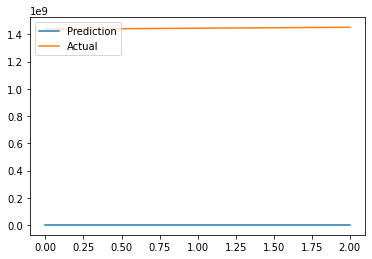

In [253]:
plt.plot(train_results6['Train Predictions'])
plt.plot(train_results6['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [254]:
val_predictions6 = model6.predict(X_val2).flatten()
val_results6 = pd.DataFrame(data={'Val Predictions':val_predictions6, 'Actuals':y_val2})
val_results6

1/1 [==============================] - 0s 15ms/step


,Val Predictions,Actuals
0,680455.0,1459378000


In [255]:
test_predictions6 = model6.predict(X_test2).flatten()
test_results6 = pd.DataFrame(data={'Test Predictions':test_predictions6, 'Actuals':y_test2})
test_results6

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,680455.0,1465634000


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


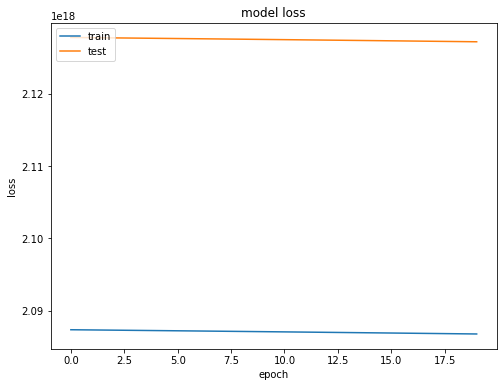

In [256]:
history = model6.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp5], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# -----------------------------

# -----------------------------

# -----------------------------

# -----------------------------

# -----------------------------

In [258]:
df = pd.read_csv("Data/Data.csv")
df = df[["country", "commodity", "year", "loss_percentage", "activity", "food_supply_stage", "cause_of_loss"]]

def focus_on(country, commodity):
    new_df = df[df.country == country]
    new_df = new_df[new_df.commodity == commodity]
    return new_df

# data = focus_on("Kenya", "Maize (corn)")
data = focus_on("Benin", "Maize (corn)")
data = data.reset_index()
data.sort_values(by=(["index"]), ascending=False, inplace=True)
data

,index,country,commodity,year,loss_percentage,activity,food_supply_stage,cause_of_loss
151,3072,Benin,Maize (corn),2000,6.42,"Drying, Harvesting",Harvest,NaN
150,3071,Benin,Maize (corn),2000,2.36,Transportation,Farm,NaN
149,3070,Benin,Maize (corn),2000,4.00,Drying,Farm,NaN
148,3069,Benin,Maize (corn),2000,3.05,Storage,Farm,NaN
147,3068,Benin,Maize (corn),2000,1.65,Transportation,Transport,NaN
...,...,...,...,...,...,...,...,...
4,2452,Benin,Maize (corn),2020,2.36,Transportation,Farm,NaN
3,2451,Benin,Maize (corn),2020,4.00,Drying,Farm,NaN
2,2450,Benin,Maize (corn),2020,6.42,"Drying, Harvesting",Harvest,NaN
1,2449,Benin,Maize (corn),2020,3.04,Storage,Farm,NaN


In [ ]:
validate = data[["activity","food_supply_stage","loss_percentage"]].tail(3)
data.drop(data.tail(3).index,inplace=True)

In [ ]:
for i in data.select_dtypes('object').columns:
    le = LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i])
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]])
Y_data = Y_scaler.fit_transform(data[['loss_percentage']])

In [ ]:
X_data

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [ ]:
hist_window = 8
horizon = 3
TRAIN_SPLIT = 120
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

In [ ]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True),
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     # tf.keras.layers.Dense(30, activation='tanh'),
     # tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.15),
     tf.keras.layers.Dense(units=horizon),
    ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:

data_val

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate["loss_percentage"],pred_Inverse[0])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['loss_percentage']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Loss Percentage")
plt.xlabel('Years (After 2000)')
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [ ]:
validate["loss_percentage"]

In [ ]:
pred_Inverse[0]

TUNING

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam','sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
    lstm_model_opt = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                    input_shape=x_train.shape[-2:]),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Dense(units=horizon),
        ])
    lstm_model_opt.compile(optimizer=hparams[HP_OPTIMIZER], loss='mse')
    lstm_model_opt.summary()
    model_path = 'Bidirectional_LSTM_Multivariate_opt.h5'
    early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min')
    checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    callbacks=[early_stopings,checkpoint]
    history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)
    (validate["loss_percentage"], pred_Inverse[0])
    return history

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    history = train_test_model(hparams)
    accuracy=model.evaluate(x_test, y_test)
    tf.summary.scalar(METRIC_ACCURACY, step=1)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
data_val = X_scaler.fit_transform(data[["activity", "food_supply_stage", "loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')


timeseries_evaluation_metrics_func(validate["loss_percentage"], pred_Inverse[0])
plt.figure(figsize=(16, 9))
plt.plot(list(validate['loss_percentage']))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual', 'predicted'))
plt.show()